- [imports](#imports)
- [settings](#settings)
- [data](#data)
  - [events](#events)
  - [spot](#spot)
  - [forward](#forward)
  - [rates](#rates)
  - [option contracts](#option-contracts)
- [methodology](#methodology)
- [results](#results)

# imports

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings  # suppress warnings
from pathlib import Path
from ipywidgets import interact

# project
from config import *
from src.visuals import *
from src.datafeed import get_daily_spot_data

# settings

In [2]:
DATA_PATH = Path("data")
MATURITY = 1/12  # maturity (approx) of options in the dataset, in years

# matplotlib
plt.style.use("seaborn-v0_8-colorblind")
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# suppress warnings
warnings.filterwarnings('ignore')

# data
Details about the data its pre-processing are given in the `1-process-data` notebook here: [link](notebooks/1-process-data.ipynb).

All data comes from Bloomberg, and contains 1-minute quotes of USDRUB option contracts, spot and forward rates, as well as the USD 1-month OIS rate as a proxy for the risk-free rate in the base currency. The quotes were retrieved shortly after the announcement and, since Bloomberg deletes high frequency data after 6 months or so, are no longer available to the best of our knowledge. Using the forward price and the USD rate, we calculate the RUB rate from the covered interest parity.

The processed data should have the format as shown below:

In [3]:
data = pd.read_feather(DATA_PATH / "processed" / "data.ftr")

# print example
data.query(f"date == '{min(data['date'])}'")\
    .style.format(precision=4)

,date,contract,value
0,2021-12-31 09:00:00+01:00,forward,75.3916
57307,2021-12-31 09:00:00+01:00,r_base,0.0008
114614,2021-12-31 09:00:00+01:00,spot,74.8688
171921,2021-12-31 09:00:00+01:00,v_10b,0.0225
229228,2021-12-31 09:00:00+01:00,v_10r,0.0827
286535,2021-12-31 09:00:00+01:00,v_25b,0.0052
343842,2021-12-31 09:00:00+01:00,v_25r,0.0384
401149,2021-12-31 09:00:00+01:00,v_atm,0.1399
458456,2021-12-31 09:00:00+01:00,r_counter,0.0812


## events

Events and their timestamps (GMT+1) are from Bloomberg, searched for using `<NEWS>`.

In [4]:
# load events data
timeline = pd.read_csv(DATA_PATH / "raw" / "timeline.csv",
                       index_col=0, parse_dates=True)\
    .squeeze()

date_t = timeline.index[-1]  # announcement of invasion

timeline.to_frame().style.format()

,event
date,
2022-02-11 11:34:58+01:00,blinken warns russia can attack during the olympics
2022-02-11 20:03:18+01:00,jake sullivan believes putin has decided to invade next week
2022-02-17 15:19:39+01:00,biden estimates prob of invasion as very high
2022-02-18 22:58:43+01:00,biden warns russia is planning attack in coming days
2022-02-24 04:06:03+01:00,putin announces special military operation


## spot
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.  To see at which level the rate eventually stabilized (kind of), we also pull daily spot data.

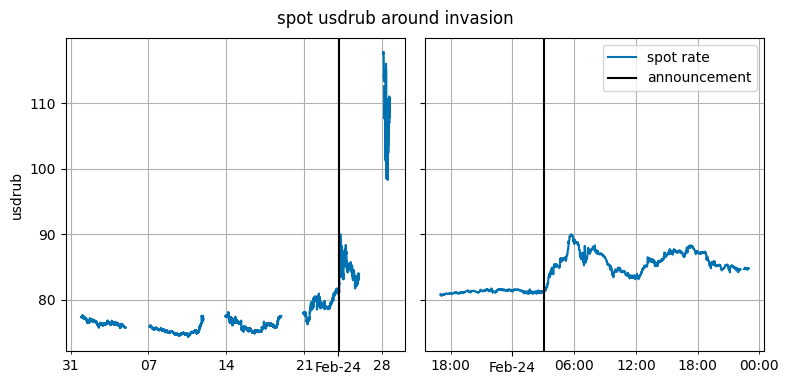

In [5]:
# load high frequency spot data
data_spot = data.query("contract == 'spot'").drop("contract", axis=1)

# plot spot exchange rate dynamics
plot_spot(data_spot.set_index("date").squeeze(), timeline)
plt.show()

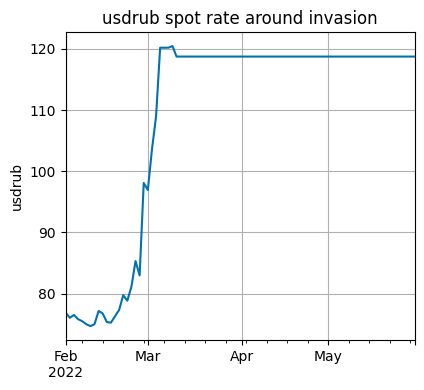

In [6]:
fig, ax = plt.subplots(figsize=(4.5, 4))
get_daily_spot_data("data/raw/usdrub-data-d.xlsx").loc["2022-02":"2022-05"]\
    .plot(ax=ax)
ax.set_xlabel("", visible=None)
ax.set_ylabel("usdrub")
ax.set_title("usdrub spot rate around invasion")
ax.grid(axis="both")
plt.show()

## forward
1-month forward quotes are from Bloomberg:

In [7]:
# load forward data
data_forward = data.query("contract == 'forward'").drop("contract", axis=1)

## rates
USD rates are 1-month OIS rates; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

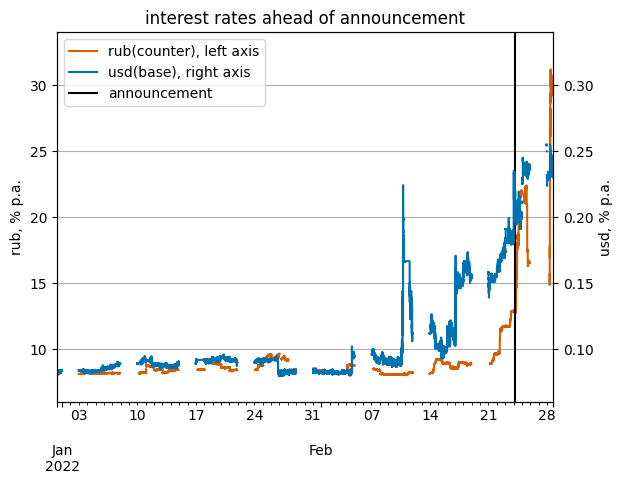

In [8]:
# interest rates data: 'r_counter' for the RUB rate, 'r_base' for the USD rate.
data_rates = data.query("contract in ('r_base', 'r_counter')")\
    .pivot(index="date", columns="contract", values="value")

plot_rates(data_rates * 100, timeline)

plt.show()

## option contracts

FX options are quoted in terms of implied volatilities (henceforth "IV") of "at-the-money" contracts, as well as 10- and 25-delta "butterfly spreads" (aka "market strangles") and "risk reversals". The exact definitions of these differ between currency pairs, and I refer the reader to the excellent book ["Foreign Exchange Option Pricing: A Practitioner's Guide"](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y) by Iain Clark for further details. In what follows, `v_atm` references the at-the-money IV, `v_10b` (`v_25b`) &mdash; the IV of the 10-delta (25-delta) market strangle and `v_10r` (`v_25r`) &mdash; the IV of the 10-delta (25-delta) risk reversal. All IV values are in fractions of 1 per annum.

In [9]:
# option contracts data
data_opt = data.loc[data["contract"].str.startswith("v_")]\
    .pivot(index="date", columns="contract", values="value")

format_dataframe(data_opt.dropna().tail(), precision=4)

date,v_10b,v_10r,v_25b,v_25r,v_atm
2022-02-28 16:27,0.1460,0.4581,0.0377,0.2122,0.8563
2022-02-28 16:30,0.1461,0.4584,0.0377,0.2123,0.8563
2022-02-28 16:32,0.1462,0.4587,0.0377,0.2124,0.8563
2022-02-28 16:36,0.1463,0.4593,0.0377,0.2127,0.8563
2022-02-28 16:44,0.1467,0.4603,0.0377,0.2132,0.8548


# methodology
Full description of the methodology, including an example, is given in the corresponding notebook here: [link](notebooks/2-methodology.ipynb). Below we provide a brief summary only.

To estimate the probability of the spot rate exceeding a certain threshold, we integrate the risk-neutral density of the spot rate extracted non-parametrically over a suitable domain. The well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents) equates (up to a proportionality constant) the risk-neutral density of the underlying $q(S)$ to the second derivative of the option pricing function $C(\cdot)$ w.r.t. the strike price $K$:

$$q(S) \propto \frac{\partial^2 C(S,K,\ldots)}{\partial K^2}.$$

Here, we take $C$ to be the Black-Scholes pricing function evaluated at $K$ and the SABR implied volatilitiy at the level of $K$:

$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$

where $\hat{\sigma}(K)$ is the SABR volatility smile calibrated to the FX option contracts. We evaluate the second derivative (for density) and the integral thereof (for probability of breaching a threshold) numerically. We also always normalize the density to sum up to one before proceeding to integration.

# results

For every datetime with enough observations, we calculate the probability that USDRUB exceeds a certain threshold when the contracts mature.  

In [10]:
# non-parametric density, integrated from different levels upwards
fname = "output/estimates/probability.csv"
p = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .rename(columns=int)

Let's plot the estimates! As before, solid vertical black line marks the invasion, and the dotted lines &ndash; the warnings issued by the US officials. 

In [11]:
@interact
def _plot_invasion_probability(threshold=p.columns):
    plot_invasion_probability(p[threshold], timeline)
    plt.show()

interactive(children=(Dropdown(description='threshold', options=(85, 90, 95, 100), value=85), Output()), _dom_…

The estimated probability of invasion oscillated around 5% for the threshold of 85, but rose to ~20% at the end of Feb 21st and 30% at the end of Feb 23rd, indicative of the FX markets growing more wary of the approaching invasion at least two days before it. Only the first two of the four warnings by the US officials had a noticeable effect on the probability.